In [2]:
import sys
import os

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor, Resize, Compose

from tqdm import tqdm

import matplotlib.pyplot as plt

In [3]:
class Inception(nn.Module):
    # output channels 
    def __init__(self, in_channels: int, bc1: int, bc2: [], bc3: [], bc4: int):
        super().__init__()
        self.b1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=bc1, kernel_size=1),
            nn.ReLU()
        )
        self.b2 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=bc2[0], kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=bc2[0], out_channels=bc2[1], kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.b3 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=bc3[0], kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=bc3[0], out_channels=bc3[1], kernel_size=5, padding=2),
            nn.ReLU()
        )
        self.b4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels=in_channels, out_channels=bc4, kernel_size=1)
        )

    def forward(self, x):
        return torch.concat(
            (self.b1(x), self.b2(x), self.b3(x), self.b4(x)),
            dim=1
        )
     
sample = torch.rand((1,1,28,28))
model = Inception(1, 6, [3, 6], [4, 6], 6)
print(sample.shape, "--->", model(sample).shape)
model

torch.Size([1, 1, 28, 28]) ---> torch.Size([1, 24, 28, 28])


Inception(
  (b1): Sequential(
    (0): Conv2d(1, 6, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
  )
  (b2): Sequential(
    (0): Conv2d(1, 3, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (b3): Sequential(
    (0): Conv2d(1, 4, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(4, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (3): ReLU()
  )
  (b4): Sequential(
    (0): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
    (1): Conv2d(1, 6, kernel_size=(1, 1), stride=(1, 1))
  )
)

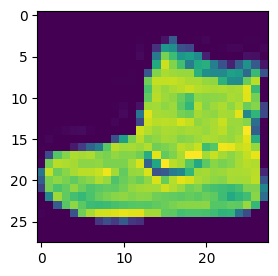

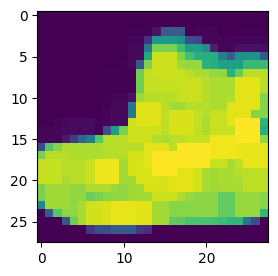

In [4]:
import torch.nn.functional as F
x = FashionMNIST(root="../datasets/", train=True, transform=ToTensor()).data[0].unsqueeze(dim=0).unsqueeze(dim=0).type(torch.float)
plt.figure(figsize=(3,3))
plt.imshow(x.squeeze())
plt.figure(figsize=(3,3))
plt.imshow(F.max_pool2d(input=x, kernel_size=3, stride=1, padding=1).squeeze())